
#   Imports and configuration


In [2]:

import os
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# For interactive widgets in Jupyter
from ipywidgets import interact, FloatRangeSlider, Layout

# Ensure figures appear inline in the notebook
%matplotlib inline



# Load CSV data and define interactive filtering

In [14]:

CSV_INPUT = "/Users/xiaodong/Desktop/UOX-data/UOX1_sub/centers.csv"
CSV_FILTERED_OUTPUT_BASENAME = "filtered_centers.csv"  # We'll create the output in the same folder

# Attempt to load the CSV file
try:
    df = pd.read_csv(CSV_INPUT)
    print(f"Loaded {len(df)} rows from {CSV_INPUT}")
except FileNotFoundError:
    print(f"ERROR: The file {CSV_INPUT} was not found. Please check the path.")
    df = pd.DataFrame()

# Define default range values for the sliders from the dataset
x_min_default = df['center_x'].min() if not df.empty else 0
x_max_default = df['center_x'].max() if not df.empty else 1000

y_min_default = df['center_y'].min() if not df.empty else 0
y_max_default = df['center_y'].max() if not df.empty else 1000


def filter_and_plot(x_range, y_range):
    """
    Filter the DataFrame (df) by center_x and center_y ranges and
    display a scatter plot of the filtered data with summary statistics.
    
    Parameters
    ----------
    x_range : tuple(float, float)
        The (min, max) range for 'center_x'.
    y_range : tuple(float, float)
        The (min, max) range for 'center_y'.
    """
    if df.empty:
        print("No data loaded. Exiting.")
        return

    # Unpack the slider values
    x_min, x_max = x_range
    y_min, y_max = y_range
    
    # Filter the data
    filtered = df[
        (df['center_x'] >= x_min) & (df['center_x'] <= x_max) &
        (df['center_y'] >= y_min) & (df['center_y'] <= y_max)
    ]
    
    # Print out descriptive statistics
    print("=== Filtered Data Statistics ===")
    print(f"Number of rows: {len(filtered)}")
    for col in ['center_x', 'center_y']:
        mean_val = filtered[col].mean()
        median_val = filtered[col].median()
        std_val = filtered[col].std()
        print(f"{col} => mean: {mean_val:.3f}, median: {median_val:.3f}, std: {std_val:.3f}")
    
    # Save the filtered data to a new CSV file in the same folder
    output_folder = os.path.dirname(CSV_INPUT)
    output_filename = os.path.join(output_folder, CSV_FILTERED_OUTPUT_BASENAME)
    filtered.to_csv(output_filename, index=False)
    print(f"\nFiltered CSV saved to: {output_filename}\n")
    
    # Plot the scatter of the filtered centers
    plt.figure(figsize=(8, 6))
    plt.scatter(filtered['center_x'], filtered['center_y'], marker='o')
    plt.xlabel('Center X')
    plt.ylabel('Center Y')
    plt.title('Scatter Plot of Center Coordinates')
    plt.grid(True)
    plt.show()

# Create an interactive widget for filtering
_ = interact(
    filter_and_plot,
    x_range=FloatRangeSlider(
        value=(x_min_default, x_max_default),
        min=x_min_default, max=x_max_default, step=0.1,
        description='X range',
        layout=Layout(width='800px')
    ),
    y_range=FloatRangeSlider(
        value=(y_min_default, y_max_default),
        min=y_min_default, max=y_max_default, step=0.1,
        description='Y range',
        layout=Layout(width='800px')
    )
)


Loaded 100 rows from /Users/xiaodong/Desktop/UOX-data/UOX1_sub/centers.csv


interactive(children=(FloatRangeSlider(value=(508.1323776567932, 509.6271549223025), description='X range', la…


#  Plot the filtered CSV data over frames

Loaded filtered data (100 rows) from /Users/xiaodong/Desktop/UOX-data/UOX1_sub/filtered_centers.csv


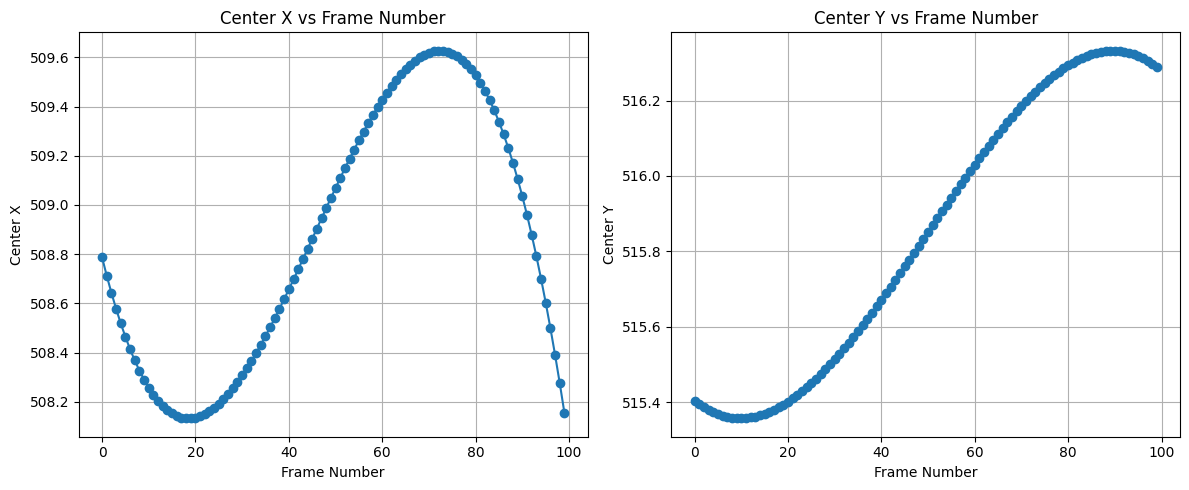

In [15]:

filtered_csv_path = os.path.join(os.path.dirname(CSV_INPUT), CSV_FILTERED_OUTPUT_BASENAME)
try:
    df_filtered = pd.read_csv(filtered_csv_path)
    print(f"Loaded filtered data ({len(df_filtered)} rows) from {filtered_csv_path}")
except FileNotFoundError:
    print("ERROR: filtered_centers.csv not found. Have you run the filtering above?")
    df_filtered = pd.DataFrame()

if not df_filtered.empty:
    plt.figure(figsize=(12, 5))
    
    # Left subplot: center_x vs frame_number
    plt.subplot(1, 2, 1)
    plt.plot(df_filtered["frame_number"], df_filtered["center_x"], marker='o')
    plt.title("Center X vs Frame Number")
    plt.xlabel("Frame Number")
    plt.ylabel("Center X")
    plt.grid(True)

    # Right subplot: center_y vs frame_number
    plt.subplot(1, 2, 2)
    plt.plot(df_filtered["frame_number"], df_filtered["center_y"], marker='o')
    plt.title("Center Y vs Frame Number")
    plt.xlabel("Frame Number")
    plt.ylabel("Center Y")
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()



#  Compare CSV and HDF5 centers

In [29]:
%matplotlib qt
# Here we load the data from the HDF5 file and compare it to the (already filtered) CSV data.

H5_INPUT = "/home/bubl3932/files/UOX1/UOX1_min_15_peak/UOX1_min_15_peak.h5"

try:
    with h5py.File(H5_INPUT, "r") as h5_file:
        center_x_h5 = h5_file["/entry/data/center_x"][:]
        center_y_h5 = h5_file["/entry/data/center_y"][:]
    print(f"Loaded HDF5 data from {H5_INPUT}")
except FileNotFoundError:
    print("ERROR: HDF5 file not found.")
    center_x_h5, center_y_h5 = [], []

if len(center_x_h5) > 0 and not df_filtered.empty:
    # Create a corresponding frame number array for HDF5 data
    frame_numbers_h5 = np.arange(len(center_x_h5))
    
    # Plot both CSV and HDF5 data
    plt.figure(figsize=(12, 6))

    # CSV data (center_x and center_y)
    plt.plot(df_filtered["frame_number"], df_filtered["center_x"], 
             marker='o', linestyle='', label='CSV center_x')
    plt.plot(df_filtered["frame_number"], df_filtered["center_y"],
             marker='o', linestyle='', label='CSV center_y')

    # HDF5 data (center_x and center_y)
    plt.plot(frame_numbers_h5, center_x_h5, 
             marker='x', linestyle='--', label='HDF5 center_x')
    plt.plot(frame_numbers_h5, center_y_h5, 
             marker='x', linestyle='--', label='HDF5 center_y')
    
    plt.xlabel("Frame Number")
    plt.ylabel("Center Coordinate Value")
    plt.title("Center Coordinates (Filtered CSV vs HDF5)")
    plt.legend()
    plt.grid(True)
    plt.show()


Loaded HDF5 data from /home/bubl3932/files/UOX1/UOX1_min_15_peak/UOX1_min_15_peak.h5


MESA: error: ZINK: failed to choose pdev
glx: failed to create drisw screen
